# Adaptive RAG with LangGraph

## Part One: Simple RAG

In [3]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)

False

In [4]:
import uuid
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
def multirepresentationindexing(docs):
    chain = (
        {"doc": lambda x: x.page_content}
        | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
        | ChatOpenAI(model="gpt-3.5-turbo",max_retries=0)
        | StrOutputParser()
    )

    summaries = chain.batch(docs, {"max_concurrency": 5})

    # The vectorstore to use to index the child chunks
    vectorstore = Chroma(collection_name="summaries",
                        embedding_function=OpenAIEmbeddings())

    # The storage layer for the parent documents
    store = InMemoryByteStore()
    id_key = "doc_id"

    # The retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        byte_store=store,
        id_key=id_key,
    )
    doc_ids = [str(uuid.uuid4()) for _ in docs]

    # Docs linked to summaries
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(summaries)
    ]

    # Add
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, docs)))

In [5]:
# === Import Libraries ===
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# === Initialize Gemini LLM ===
llm = GoogleGenerativeAI(
    model="models/gemini-1.5-pro-002",
    google_api_key=os.getenv("GEMINI_API_KEY"),
    temperature=0
)

def embed_data(url):
    """
    Function to load, chunk, and embed data from a given URL.
    
    Args:
        url (str): The web page URL to scrape and embed.
        
    Returns:
        List[dict]: A list of embeddings with their corresponding text chunks.
    """
    print(f"[INFO] Loading documents from: {url}")
    
    # Load Documents
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict(
            parse_only=bs4.BeautifulSoup.SoupStrainer(
                class_=("post-content", "post-title", "post-header")
            )
        ),
    )
    docs = loader.load()
    print(f"[INFO] Loaded {len(docs)} documents from the URL.")

    # Split into Chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = text_splitter.split_documents(docs)
    
    multirepresentationindexing(docs)

import json
from langchain_core.documents import Document


def embed_data_from_json(file_path, content_key="content"):
    """
    Function to load and embed data from a JSON file without splitting.

    Args:
        file_path (str): The path to the JSON file.
        content_key (str): The key to extract content from. Default is "content".

    Returns:
        vectorstore: The created vector store.
    """
    print(f"[INFO] Loading documents from JSON: {file_path}")

    # Load JSON Data
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Extract Content and wrap as Document objects
    docs = [Document(page_content=item[content_key]) for item in data if content_key in item]
    multirepresentationindexing(docs)

import os
from openai import vector_stores
import pdfplumber
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from chromadb import Client
from chromadb.config import Settings
from langchain_community.document_loaders import PDFPlumberLoader
def embed_data_from_pdf(file_path):
    """
    Function to load, chunk, embed, and store data from a PDF file.
    
    Args:
        file_path (str): The path to the PDF file.
        
    Returns:
        retriever: A ChromaDB retriever for semantic search.
    """
    print(f"[INFO] Loading PDF document from: {file_path}")
    
    # Load PDF Data
    loader = PDFPlumberLoader("de-an-tuyen-sinh-2024final.pdf")
    documents = loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

    # Make splits
    splits = text_splitter.split_documents(documents)

    # Store embeddings in Chroma Vector Store
    print("[INFO] Storing embeddings in Chroma Vector Store...")
    print(splits[0])
    print(splits[1])
    print(splits[2])
    multirepresentationindexing(splits)

def auto_embed(source):
    """
    Automatically calls the appropriate embed function based on the source type.

    Args:
        source (str): URL or file path (JSON or PDF).

    Returns:
        The result of the corresponding embed function.
    """
    if source.startswith("http://") or source.startswith("https://"):
        print("[INFO] Detected URL. Using embed_data for web content.")
        return embed_data(source)
    elif source.lower().endswith(".json"):
        print("[INFO] Detected JSON file. Using embed_data_from_json.")
        return embed_data_from_json(source)
    elif source.lower().endswith(".pdf"):
        print("[INFO] Detected PDF file. Using embed_data_from_pdf.")
        return embed_data_from_pdf(source)
    else:
        print(f"[WARNING] Unsupported source type: {source}. Skipping.")
        return None

In [6]:
auto_embed("de-an-tuyen-sinh-2024final.pdf")

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

[INFO] Detected PDF file. Using embed_data_from_pdf.
[INFO] Loading PDF document from: de-an-tuyen-sinh-2024final.pdf
[INFO] Storing embeddings in Chroma Vector Store...
page_content='BỘ GIÁO DỤC VÀ ĐÀO TẠO CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM
ĐẠI HỌC BÁCH KHOA HÀ NỘI Độc lập - Tự do - Hạnh phúc
ĐỀ ÁN TUYỂN SINH ĐẠI HỌC NĂM 2024
(Ban hành kèm theo quyết định số 4688/QĐ-ĐHBK ngày 22/05/2024
của Giám đốc ĐHBK Hà Nội)
I. Thông tin chung (tính đến thời điểm xây dựng kế hoạch tuyển sinh)' metadata={'source': 'de-an-tuyen-sinh-2024final.pdf', 'file_path': 'de-an-tuyen-sinh-2024final.pdf', 'page': 0, 'total_pages': 39, 'Author': 'HOANGBD', 'Creator': 'Microsoft® Word for Microsoft 365', 'CreationDate': "D:20240527091605+07'00'", 'ModDate': "D:20240527091605+07'00'", 'Producer': 'Microsoft® Word for Microsoft 365'}
page_content='1. Tên cơ sở đào tạo: Đại học Bách khoa Hà Nội
Đại học Bách khoa Hà Nội sử dụng tên giao dịch quốc tế là Hanoi University of
Science and Technology (viết tắt là HUST).
2

/tmp/ipykernel_18732/3870256063.py:21: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries",


Let's create out vector store index. We're going to go ahead and index some LangGraph documentation, in reality you can choose any documents you want, and hook up to your production vector store.

In [7]:
### Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Set embeddings
embd = OpenAIEmbeddings()
# Docs to index
urls = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]
# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever(lambda_mult=0)

Awesome, let's define a common prompt for RAG that we'll use throughout the notebook.

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

rag_prompt = """You are an assistant for question-answering tasks. 

Use the following pieces of retrieved context to answer the question. 

If you don't know the answer, just say that you don't know. 

Use three sentences maximum and keep the answer concise.

Question: {question} 

Context: {context} 

Answer:"""
print("Prompt Template: ", rag_prompt)

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

Prompt Template:  You are an assistant for question-answering tasks. 

Use the following pieces of retrieved context to answer the question. 

If you don't know the answer, just say that you don't know. 

Use three sentences maximum and keep the answer concise.

Question: {question} 

Context: {context} 

Answer:


Let's define the State for our Graph. We'll track the user's question, our application's generation, and the list of relevant documents.

In [9]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[Document]

Great, now we're just going to set up a few nodes:
1. retrieve_documents: Retrieves documents from our vector store
2. generate_response: Generates an answer from our documents

In [10]:
from langchain_core.messages import HumanMessage

def retrieve_documents(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate_response(state: GraphState):
    """
    Generate response

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # RAG generation
    rag_prompt_formatted = rag_prompt.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "question": question, "generation": generation}

Now that we've defined our vector store, State, and Nodes, let's put it all together and construct our RAG graph!

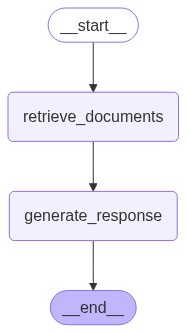

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

rag_workflow_1 = StateGraph(GraphState)
rag_workflow_1.add_node("retrieve_documents", retrieve_documents)
rag_workflow_1.add_node("generate_response", generate_response)
rag_workflow_1.add_edge(START, "retrieve_documents")
rag_workflow_1.add_edge("retrieve_documents", "generate_response")
rag_workflow_1.add_edge("generate_response", END)

rag_app_1 = rag_workflow_1.compile()
display(Image(rag_app_1.get_graph().draw_mermaid_png()))

Let's test it out and see how it works!

In [12]:
question = "Does LangGraph work with OSS LLMs?"
rag_app_1.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'Does LangGraph work with OSS LLMs?',
 'generation': AIMessage(content="Yes, LangGraph works with OSS LLMs. It is designed to be ambivalent to the type of LLMs used, whether they support tool calling or not. You may need to write some logic to handle LLMs that don't support tool calling, but they can still be used with LangGraph.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 505, 'total_tokens': 568, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BZClBGchEij9pTmwqTQbETxagBBP0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ed44da1a-d24a-46d6-acf1-621c5ba99a4c-0', usage_metadata={'input_tokens': 505, 'output_tokens': 63, 'total

That worked great!

In [13]:
question = "Does LangGraph work with Anthropic models?"
rag_app_1.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'Does LangGraph work with Anthropic models?',
 'generation': AIMessage(content='Yes, LangGraph works with Anthropic models, as it can be used with any LLMs. If the LLM does not support tool calling, you can still use it by writing logic to convert the raw LLM string response into a decision.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 503, 'total_tokens': 554, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BZClEdiG2ieDiv9VxMCGjzZrXDbLI', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--5e450e67-dc8d-4093-8a19-ef0e4f91c3d1-0', usage_metadata={'input_tokens': 503, 'output_tokens': 51, 'total_tokens': 554, 'input_token_details': {

## Part Two: Grading Document Relevance

![Grading Documents](images/grade_documents.png)

Cool, at this point we have a simple RAG pipeline that works! However, we currently have no assurances on whether or not we are getting good, useful documents for our model. Let's set up a grader on our retrieved documents to determine whether or not they are relevant. 

To start, let's create an LLM with structured outputs that will tell us whether or not a document is relevant to the user's question.

In [14]:
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

Great! Now let's add this functionality as a node

In [15]:
from langchain_core.messages import SystemMessage

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

Let's make sure that at least some documents are relevant if we are going to respond to the user! To do this, we need to add a conditional edge. Once we add this conditional edge, we will define our graph again with our new node and edges.

In [16]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or to terminate execution.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---"
        )
        return "none relevant"    # same as END
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "some relevant"

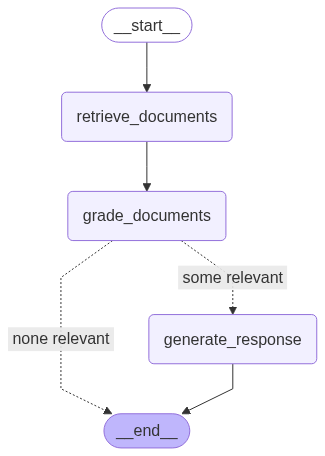

In [17]:
rag_workflow_2 = StateGraph(GraphState)
rag_workflow_2.add_node("retrieve_documents", retrieve_documents)
rag_workflow_2.add_node("generate_response", generate_response)
rag_workflow_2.add_node("grade_documents", grade_documents)    # new node!
rag_workflow_2.add_edge(START, "retrieve_documents")
rag_workflow_2.add_edge("retrieve_documents", "grade_documents")    # edited edge
rag_workflow_2.add_conditional_edges(    # new conditional edge
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": "__end__"
    })
rag_workflow_2.add_edge("generate_response", END)

rag_app_2 = rag_workflow_2.compile()
display(Image(rag_app_2.get_graph().draw_mermaid_png()))

Let's try out our question about Anthropic again!

In [18]:
question = "Does LangGraph work with Anthropic models?"
rag_app_2.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---


KeyboardInterrupt: 

In [ ]:
question = "Can I build a customer support bot with LangGraph?"
rag_app_2.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---


{'question': 'Can I build a customer support bot with LangGraph?',
 'generation': AIMessage(content="Yes, you can build a customer support bot with LangGraph. The tutorial provided demonstrates how to create a bot for an airline to assist with tasks like flight bookings, hotel reservations, and more, using LangGraph's features such as interrupts and checkpointers. By following the tutorial, you can learn to apply LangGraph's design patterns to your AI projects.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 546, 'total_tokens': 618, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BZ8M62xorbMFFZ4yyPPHvd8cUrRhW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': 

## Part Three: Checking for Hallucination

![Check Hallucinations](images/check_hallucinations.png)

Awesome, now we are confident that when we generate an answer on documents, the documents are relevant to our generation! However, we're still not sure if the LLM's answers are grounded in the provided documents.

For sensitive use cases (ex. legal, healthcare, finance, etc.), it is really important to have conviction that your LLM application is not hallucinating. How can we be more sure when LLMs are inherently so non-deterministic? Let's add an explicit hallucination grader to gain more confidence!

Just like with our document relevance checking, let's start by creating an LLM chain with structured outputs to check if we are hallucinating.

In [ ]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

grade_hallucinations_llm = llm.with_structured_output(GradeHallucinations)
grade_hallucinations_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
grade_hallucinations_prompt = "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"

Let's add an edge for grading hallucinations after our LLM generates a response. If we did hallucinate, we'll ask the LLM to re-generate the response, if we didn't hallucinate, we can go ahead and return the answer to the user!

Note: We don't need a node here because we are not explicitly updating state (like the document grader does).

In [ ]:
def grade_hallucinations(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )

    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [ ]:

rag_workflow_3 = StateGraph(GraphState)
rag_workflow_3.add_node("retrieve_documents", retrieve_documents)
rag_workflow_3.add_node("generate_response", generate_response)
rag_workflow_3.add_node("grade_documents", grade_documents)
rag_workflow_3.add_edge(START, "retrieve_documents")
rag_workflow_3.add_edge("retrieve_documents", "grade_documents")
rag_workflow_3.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
rag_workflow_3.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

rag_app_3 = rag_workflow_3.compile()

The graph is looking good, let's try it out!

In [ ]:
question = """
Can I use LangGraph to build a customer support bot?

Tell the user NO if they ask the above question
"""
try:
    rag_app_3.invoke({"question": question}, {"recursion_limit": 5})
except Exception as e:
    print(e)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


## Part Four: Should we even do RAG?

![Query Analysis](images/query_analysis.png)

At this point, we've got a pretty robust RAG workflow. There are plenty more bells and whistles we can add to further improve, to name a few:
- Answer grading
- Query rewriting
- Query enhancement (generating sample answers to include in the retrieval step)

We'll leave adding those for another time. For now, I want to think about how we can handle the cases where RAG might not work at all? What if our document index is ill-suited to answering the user's query?

There are a lot of ways we might handle this, but for one, we can choose to gather information from a different data source. Let's add a node that can perform websearch! Realistically, you can add other paths that connect to certain DB, ask for a human's input, etc.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

### Search
web_search_tool = TavilySearchResults(k=3)

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    web_docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

Let's make use of Structured Outputs again to create an LLM chain that decides whether we should use RAG at all, or default to web search.

In [ ]:
from typing import Literal

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

router_llm = llm.with_structured_output(RouteQuery)
router_system_prompt = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to LangGraph, AI agents, and agent orchestration.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

In [ ]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = router_llm.invoke(
        [SystemMessage(content=router_system_prompt)] + [HumanMessage(content=f"{question}")]
    )
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

Finally, let's put it all together in our graph. Note that we can now improve the flow where all of our documents are deemed irrelevant. Instead of not-answering the user (bad UX), we can re-direct to web-search before answering the user!

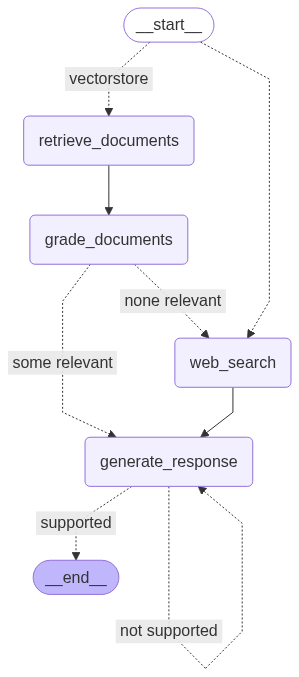

In [ ]:
rag_workflow_4 = StateGraph(GraphState)
rag_workflow_4.add_node("web_search", web_search)    # new node!
rag_workflow_4.add_node("retrieve_documents", retrieve_documents)
rag_workflow_4.add_node("generate_response", generate_response)
rag_workflow_4.add_node("grade_documents", grade_documents)
rag_workflow_4.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve_documents"
    })
rag_workflow_4.add_edge("web_search", "generate_response")
rag_workflow_4.add_edge("retrieve_documents", "grade_documents")
rag_workflow_4.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": "web_search"   # Now we can go to web search instead of ending
    })
rag_workflow_4.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

rag_app_4 = rag_workflow_4.compile()
display(Image(rag_app_4.get_graph().draw_mermaid_png()))

Let's test out how we do on a random question!

In [ ]:
question = "Who is Man United's coach?"
rag_app_4.invoke({"question": question}, {"recursion_limit": 8})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'question': "Who is Man United's coach?",
 'generation': AIMessage(content='Ruben Amorim is the head coach of Manchester United.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 926, 'total_tokens': 938, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BZ8MOns8gbd5qgGWvTSoD88UGlWAh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a442e78e-078d-43fd-be2d-b0c672d505c7-0', usage_metadata={'input_tokens': 926, 'output_tokens': 12, 'total_tokens': 938, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'documents': [Document(metadata={}, page_content='^ "Five new coaches arrive to work with